# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        #для хранения loss на каждой операции
        self.loss_list = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1.0 / (1 + np.exp(-(X @ weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        #N = x.shape()[0] #samples count
        #n = x.shape()[1] #features count
        loss = np.mean(np.log(1+np.exp(-np.transpose(x.dot(self.weights_))*y_train)))+1/(2*self.C)*np.linalg.norm(self.weights_)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
       
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            
            delta = -np.mean(np.transpose((np.transpose(X_ext)*y)*(1-(1/(1+np.exp(-np.transpose((np.transpose(X_ext.dot(self.weights_))*y))))))),axis=0)+1/self.C*self.weights_
            self.weights_ -= self.eta * delta
            
            # для анализа изменения loss от итерации
            self.loss_list.append(self.get_loss(X_ext, self.weights_,y))
            
            #if np.linalg.norm(delta) < self.tol: #
            if np.sqrt(np.sum(delta**2)) < self.tol:
                break
        
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return [1 if i > 0.5 else -1 for i in self.predict_proba(X)]
        

In [5]:
from sklearn import datasets
from sklearn import metrics

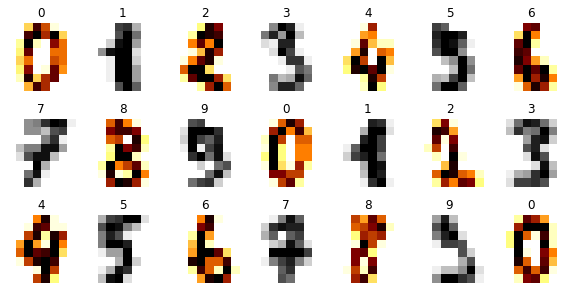

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


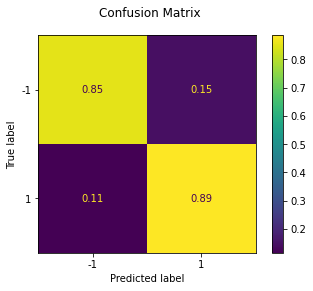

(0.8406402226861517, 0.8694444444444445)

In [12]:
fit_evaluate(lr_clf,X_train, y_train, X_test, y_test)
# для 1 итерации accurancy_score (TP+TN)/ (TP+FN+TN+FP) 
#на тренировочный и тестовых (0.8406402226861517, 0.8694444444444445) соответветсвенно

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


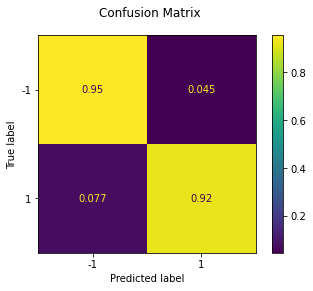

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)


In [16]:
train_acc, test_acc
# на 1000 интерациях accurancy_score (TP+TN)/ (TP+FN+TN+FP) 
# на тренировочный и тестовых (0.9109255393180237, 0.9388888888888889) соответветсвенно

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

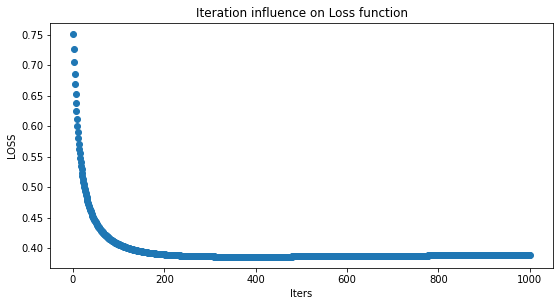

Оптимальное кол-чество итераций: 380


In [18]:
## your code
## посмотрим изменение Loss от числа иттераций
## для этого в класс добавим loss_list, для хрения значений loss на каждой итерации
import seaborn as sns
import matplotlib.pyplot as plt


ITERS = np.linspace(1, 1000, 1 + 999, dtype=int)

def plot_fit(y, x,xlabel='', ylabel='', custom_scale = 'log',label = 'Traning sample', title = 'Iteration influence on Loss function'):
    plt.figure(figsize=(9, 4.5))
    plt.scatter(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_fit(model.loss_list, ITERS, 'Iters','LOSS')
print(f'Оптимальное кол-чество итераций: {ITERS[np.argmin(model.loss_list)]}')


Увеличение числа итераций, как и ожидалось приводит, к уменьшению Loss.Оптимальное кол-чество итераций: 380. Дальнейшее увеличение итераций приводит к незначительному увеличению метрики.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

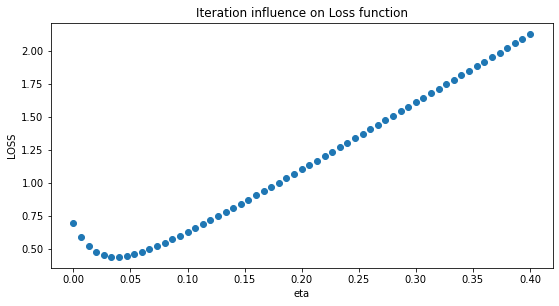

Оптимальное eta: 0.04 для 1 итерации


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


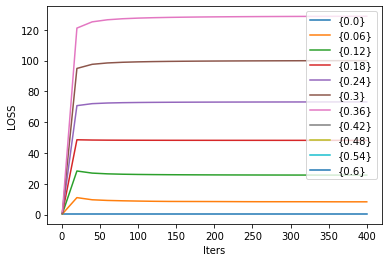

In [19]:
## your code
## Посмотрим зависимость loss от eta на 1 итерации
# Для хранения результатов loss
loss_list2 = []
ETAS = np.linspace(0, 0.4, 1 + 60, dtype=float)
for eta in ETAS:
    model_eta = CustomLogisticRegression(max_iter = 1, eta = eta, zero_init = True)
    model_eta.fit( X_train, y_train)
    loss_list2.append(model_eta.loss_list)
plot_fit(loss_list2, ETAS, 'eta','LOSS')
print(f'Оптимальное eta: {ETAS[np.argmin(loss_list2)]} для 1 итерации')
eta_1_iter = ETAS[np.argmin(loss_list2)]

## Поcтараемся найти оптимальную смотрим eta и количество итераций
# уменьшим число выборок для eta для скорости вычисления
ETAS = np.linspace(0, 0.6, 1 + 10, dtype=float)
ITERS = np.linspace(1, 400, 1 + 20, dtype=int)
# Для хранения результатов loss
loss_list2 = []
for eta in ETAS:
    loss_list2 = []
    for iter in ITERS:
   
        model_eta = CustomLogisticRegression(max_iter = iter, eta = eta, zero_init = True)
        model_eta.fit( X_train, y_train)
        loss_list2.append(np.mean(model_eta.loss_list))
    plt.plot(ITERS, loss_list2, label={eta})
plt.legend(loc="upper right")
plt.xlabel("Iters")
plt.ylabel("LOSS")
plt.show()
   
    

Оптимальное eta: 0.037500000000000006 приоценке логистической модели для 1 итерации.Исходя из графика 2 комбинируя количество итераций и eta можно выбрать оптимальное значение для модели.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

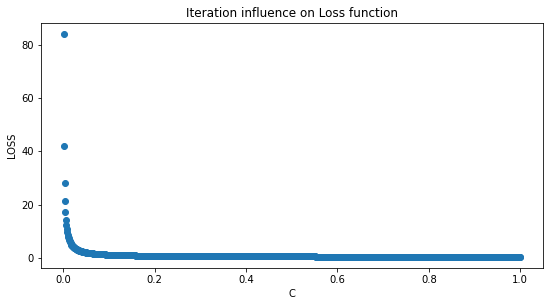

Оптимальное C: 1.0 для 1 итерации


In [20]:
## your code
C_range = np.linspace(0.001,1, 1 + 1000, dtype=float)

# Для хранения результатов loss
loss_listC = []

for C in C_range:
    model_eta = CustomLogisticRegression(max_iter = 1,C=C, eta = 0.037500000000000006, zero_init = True)
    model_eta.fit( X_train, y_train)
    loss_listC.append(model_eta.loss_list)
plot_fit(loss_listC, C_range, 'C','LOSS')
print(f'Оптимальное C: {C_range[np.argmin(loss_listC)]} для 1 итерации')
C_opt_1_iter = C_range[np.argmin(loss_listC)]

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

LOSS for zero initiation: [0.5917816162116387]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


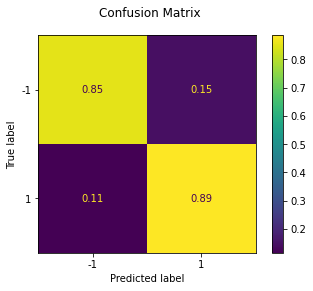

(0.8406402226861517, 0.8694444444444445)

In [21]:
## your code
# Сравним zero initialization и random initialization по метрикам loss и accurancy_score
model_zero = CustomLogisticRegression(max_iter = 1, eta = 0.006666666666666667, zero_init = True)
model_zero.fit(X_train, y_train)
print(f'LOSS for zero initiation: {model_zero.loss_list}')
fit_evaluate(model_zero, X_train, y_train, X_test, y_test)


LOSS random initiation: [0.661991309167166]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


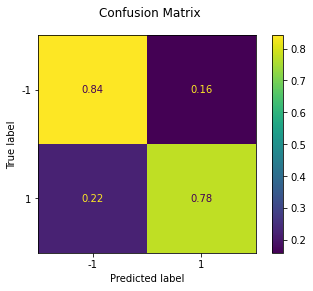

(0.7884481558803061, 0.8083333333333333)

In [22]:
model_random = CustomLogisticRegression(max_iter = 1, eta = 0.006666666666666667, zero_init = False)
model_random.fit(X_train, y_train)
print(f'LOSS random initiation: {model_random.loss_list}')
fit_evaluate(model_random, X_train, y_train, X_test, y_test)

Нулевая инициализация показала себя лучше и по метрикам loss и по accurancy score. Хотя в теории рекомендуется использовать рандомную.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [23]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        part1 = np.add.outer(np.sum(X**2, axis=1), np.sum(Y**2, axis=1))
        part2 = np.dot(X, Y.T)
        return np.sqrt(part1 - 2*part2)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        dataset = pd. DataFrame({'y': y, 'weight': list(weights)}, columns=['y', 'weight'])
       
        ds = dataset.groupby(['y'])['weight'].agg('sum')
        #сортировка для assert 
        if 'one' in dataset.values:
            return  np.array([ds['one'],ds['two'],ds['three']])
        else:
            return ds.to_numpy()
        
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            n_=np.sort(P,axis=1)[:,: self.n_neighbors]
            y_=self.y[P.argsort(axis=1)[:,: self.n_neighbors]]
            
            weights_of_point =np.ones(n_.shape)
            #weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(n_+self.eps)
            w_i=np.array([self.get_class_weights(y_[i],weights_of_points[i]) for i in range(weights_of_points.shape[0])])   
            Probability = w_i/np.sum(w_i, axis =1)[:,None]
            return Probability
            
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = predict_proba(X)
        return np.argmax(y,axis=1)

In [24]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [26]:
model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4]))

array([2, 4, 0])

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

##!!!!На этом все! Дальше не получилось реализовать.

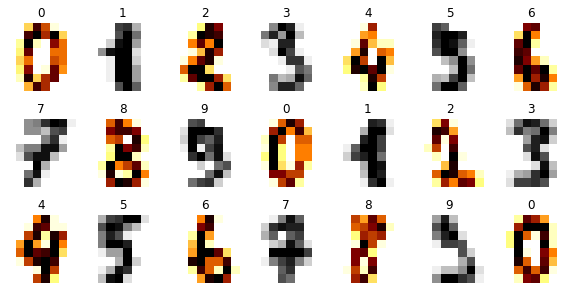

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
model.predict_proba(X_test)
#X_test.shape
#knn.predict_proba(X_test).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


AxisError: ignored

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
PATH = "./data/"

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [ ]:
data.head()

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [ ]:
## your code

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## your code

< your thoughts >

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.